# **Comparing Baseline and Recurrent Transformers on different subset sizes of the SST-2 dataset**

This notebook compares the Baseline and Recurrent transformer architectures on different subsets of the SST-2 dataset:
   
   1. **10% of the training data**
   2. **50% of the training data**

The goal is to analyze how data quantity affects the performance, convergence, and efficiency of each model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
import os
import warnings
import copy
from tqdm.notebook import tqdm # Use tqdm.notebook for Jupyter progress bars
from sklearn.metrics import f1_score, precision_score, recall_score

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


## 1. Configurations

In [ ]:
# Model configurations
BASELINE_CONFIG = {
    'hidden_size': 384,
    'num_hidden_layers': 6,
    'num_attention_heads': 6,
    'intermediate_size': 1536,
    'dropout_prob': 0.1,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

RECURRENT_CONFIG = {
    'hidden_size': 256,
    'num_hidden_layers': 3,
    'recurrent_depth': 2,  # Effective depth: 3 × 2 = 6
    'num_attention_heads': 4,
    'intermediate_size': 1024,
    'dropout_prob': 0.1,
    'residual_scale': 0.5,
    'use_flash_attention': True,
    'use_swiglu': True,
    'use_rope': True,
    'use_rms_norm': True
}

TRAINING_CONFIG = {
    'num_epochs': 5,
    'batch_size': 16,
    'learning_rate': 3e-5,
    'warmup_steps': 100,
    'eval_steps': 50,
    'max_length': 128,
    'patience': 3, # For early stopping
    'min_delta': 0.001 # For early stopping
}

DATA_SUBSETS = ['10_percent', '50_percent']

## 2. Functions for Models, Training, and Evaluation

In [ ]:
import sys
import os
PROJECT_ROOT = '/content/drive/MyDrive/5800_FinalProject'
os.chdir(PROJECT_ROOT)


from training.utils import prepare_sst2_data, load_tokenizer
from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau




def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def get_models():
    """Initializes and returns fresh instances of the models."""
    # Baseline model
    baseline_config = BaselineConfig(
        vocab_size=30522,
        hidden_size=BASELINE_CONFIG['hidden_size'],
        num_hidden_layers=BASELINE_CONFIG['num_hidden_layers'],
        num_attention_heads=BASELINE_CONFIG['num_attention_heads'],
        intermediate_size=BASELINE_CONFIG['intermediate_size'],
        hidden_dropout_prob=BASELINE_CONFIG['dropout_prob'],
        attention_probs_dropout_prob=BASELINE_CONFIG['dropout_prob'],
        num_labels=2,
        **{k: v for k, v in BASELINE_CONFIG.items() if k.startswith('use_')}
    )

    # Recurrent model
    recurrent_config = RecurrentConfig(
        vocab_size=30522,
        hidden_size=RECURRENT_CONFIG['hidden_size'],
        num_hidden_layers=RECURRENT_CONFIG['num_hidden_layers'],
        recurrent_depth=RECURRENT_CONFIG['recurrent_depth'],
        num_attention_heads=RECURRENT_CONFIG['num_attention_heads'],
        intermediate_size=RECURRENT_CONFIG['intermediate_size'],
        hidden_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
        attention_probs_dropout_prob=RECURRENT_CONFIG['dropout_prob'],
        residual_scale=RECURRENT_CONFIG['residual_scale'],
        num_labels=2,
        **{k: v for k, v in RECURRENT_CONFIG.items() if k.startswith('use_')}
    )

    baseline_model = BaselineModel(baseline_config).to(device)
    recurrent_model = RecurrentModel(recurrent_config).to(device)

    return baseline_model, recurrent_model

# Use centralized training function
from training import train_model

def evaluate_model(model, loader):
    model.eval()
    all_predictions, all_labels, inference_times = [], [], []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            start_time = time.time()
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            inference_times.append((time.time() - start_time) * 1000 / batch['input_ids'].size(0))
            predictions = outputs['logits'].argmax(dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    return {
        'accuracy': accuracy,
        'f1': f1_score(all_labels, all_predictions, average='weighted'),
        'precision': precision_score(all_labels, all_predictions, average='weighted'),
        'recall': recall_score(all_labels, all_predictions, average='weighted'),
        'inference_time_ms': np.mean(inference_times)
    }


## 3. Run Experiments

In [ ]:
PROJECT_ROOT = '/content/drive/MyDrive/5800_FinalProject'
os.chdir(PROJECT_ROOT)

tokenizer = load_tokenizer('bert-base-uncased')
all_results = []
training_histories = {}

for subset in DATA_SUBSETS:
    print(f"\n{'='*20} Experiment: {subset.replace('_', ' ').title()} {'='*20}")
    data_dir = f'data/processed_size_splits_sst2/{subset}'
    training_histories[subset] = {}

    # Load data for the current subset
    train_loader, val_loader, test_loader = prepare_sst2_data(
        data_dir=data_dir,
        tokenizer=tokenizer,
        batch_size=TRAINING_CONFIG['batch_size'],
        max_length=TRAINING_CONFIG['max_length']
    )

    # Get fresh models
    baseline_model, recurrent_model = get_models()
    models_to_run = {
        'Baseline': baseline_model,
        'Recurrent': recurrent_model
    }

    for model_name, model in models_to_run.items():
        print(f"\n--- Training {model_name} on {subset} ---")

        # Train the model
        history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            name=f"{model_name}-{subset}",
            num_epochs=TRAINING_CONFIG['num_epochs'],
            learning_rate=TRAINING_CONFIG['learning_rate'],
            patience=TRAINING_CONFIG['patience'],
            min_delta=TRAINING_CONFIG['min_delta'],
            save_dir='../checkpoints'
        )
        training_histories[subset][model_name] = history

        # Evaluate the model
        print(f"--- Evaluating {model_name} on {subset} test set ---")
        metrics = evaluate_model(model, test_loader)

        # Store results
        params = count_parameters(model)
        size_mb = params * 4 / (1024 * 1024)
        result = {
            'Model': model_name,
            'Subset': subset,
            'Parameters': params,
            'Size (MB)': size_mb,
            **metrics
        }
        all_results.append(result)
        print(f"Results for {model_name} on {subset}: Accuracy={metrics['accuracy']:.4f}, F1={metrics['f1']:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(all_results)



==================== Experiment: 10 Percent ====================
Loaded 5458 samples from data/processed_size_splits_sst2/10_percent/sst2_train.pkl
Loaded 6822 samples from data/processed_size_splits_sst2/10_percent/sst2_val.pkl
Loaded 6823 samples from data/processed_size_splits_sst2/10_percent/sst2_test.pkl

--- Training Baseline on 10_percent ---


Baseline-10_percent Epoch 1:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.6794, Val Loss=0.6077, Val Acc=0.6758


Baseline-10_percent Epoch 2:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5212, Val Loss=0.5120, Val Acc=0.7666


Baseline-10_percent Epoch 3:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.3426, Val Loss=0.5661, Val Acc=0.7825


Baseline-10_percent Epoch 4:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.2518, Val Loss=0.7495, Val Acc=0.7706


Baseline-10_percent Epoch 5:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.1977, Val Loss=0.9564, Val Acc=0.7917
Early stopping triggered at epoch 5
Loaded best model with val_loss=0.5120
--- Evaluating Baseline on 10_percent test set ---
Results for Baseline on 10_percent: Accuracy=0.7661, F1=0.7665

--- Training Recurrent on 10_percent ---


Recurrent-10_percent Epoch 1:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.6887, Val Loss=0.6548, Val Acc=0.5660


Recurrent-10_percent Epoch 2:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.5438, Val Loss=0.5463, Val Acc=0.7473


Recurrent-10_percent Epoch 3:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.3515, Val Loss=0.5866, Val Acc=0.7712


Recurrent-10_percent Epoch 4:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.2512, Val Loss=0.6849, Val Acc=0.7883


Recurrent-10_percent Epoch 5:   0%|          | 0/342 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.1999, Val Loss=0.7538, Val Acc=0.7913
Early stopping triggered at epoch 5
Loaded best model with val_loss=0.5463
--- Evaluating Recurrent on 10_percent test set ---
Results for Recurrent on 10_percent: Accuracy=0.7453, F1=0.7451

==================== Experiment: 50 Percent ====================
Loaded 27288 samples from data/processed_size_splits_sst2/50_percent/sst2_train.pkl
Loaded 6822 samples from data/processed_size_splits_sst2/50_percent/sst2_val.pkl
Loaded 6823 samples from data/processed_size_splits_sst2/50_percent/sst2_test.pkl

--- Training Baseline on 50_percent ---


Baseline-50_percent Epoch 1:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5187, Val Loss=0.3570, Val Acc=0.8473


Baseline-50_percent Epoch 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.3050, Val Loss=0.3265, Val Acc=0.8735


Baseline-50_percent Epoch 3:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.2423, Val Loss=0.3214, Val Acc=0.8817


Baseline-50_percent Epoch 4:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.2073, Val Loss=0.3902, Val Acc=0.8870


Baseline-50_percent Epoch 5:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.1844, Val Loss=0.5418, Val Acc=0.8819
Loaded best model with val_loss=0.3214
--- Evaluating Baseline on 50_percent test set ---
Results for Baseline on 50_percent: Accuracy=0.8852, F1=0.8854

--- Training Recurrent on 50_percent ---


Recurrent-50_percent Epoch 1:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.5238, Val Loss=0.4243, Val Acc=0.8201


Recurrent-50_percent Epoch 2:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.3153, Val Loss=0.3511, Val Acc=0.8613


Recurrent-50_percent Epoch 3:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.2438, Val Loss=0.3985, Val Acc=0.8644


Recurrent-50_percent Epoch 4:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.2097, Val Loss=0.4787, Val Acc=0.8789


Recurrent-50_percent Epoch 5:   0%|          | 0/1706 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.1953, Val Loss=0.4098, Val Acc=0.8868
Early stopping triggered at epoch 5
Loaded best model with val_loss=0.3511
--- Evaluating Recurrent on 50_percent test set ---
Results for Recurrent on 50_percent: Accuracy=0.8655, F1=0.8658


## 4. Analyze and Visualize Results

In [ ]:
print("\n--- Final Comparison Table ---")
display(results_df.round(4))


--- Final Comparison Table ---


,Model,Subset,Parameters,Size (MB),accuracy,f1,precision,recall,inference_time_ms
0,Baseline,10_percent,25912706,98.8491,0.7661,0.7665,0.7765,0.7661,0.3198
1,Recurrent,10_percent,10972162,41.8555,0.7453,0.7451,0.7620,0.7453,0.3084
2,Baseline,50_percent,25912706,98.8491,0.8852,0.8854,0.8862,0.8852,0.3299
3,Recurrent,50_percent,10972162,41.8555,0.8655,0.8658,0.8708,0.8655,0.3075


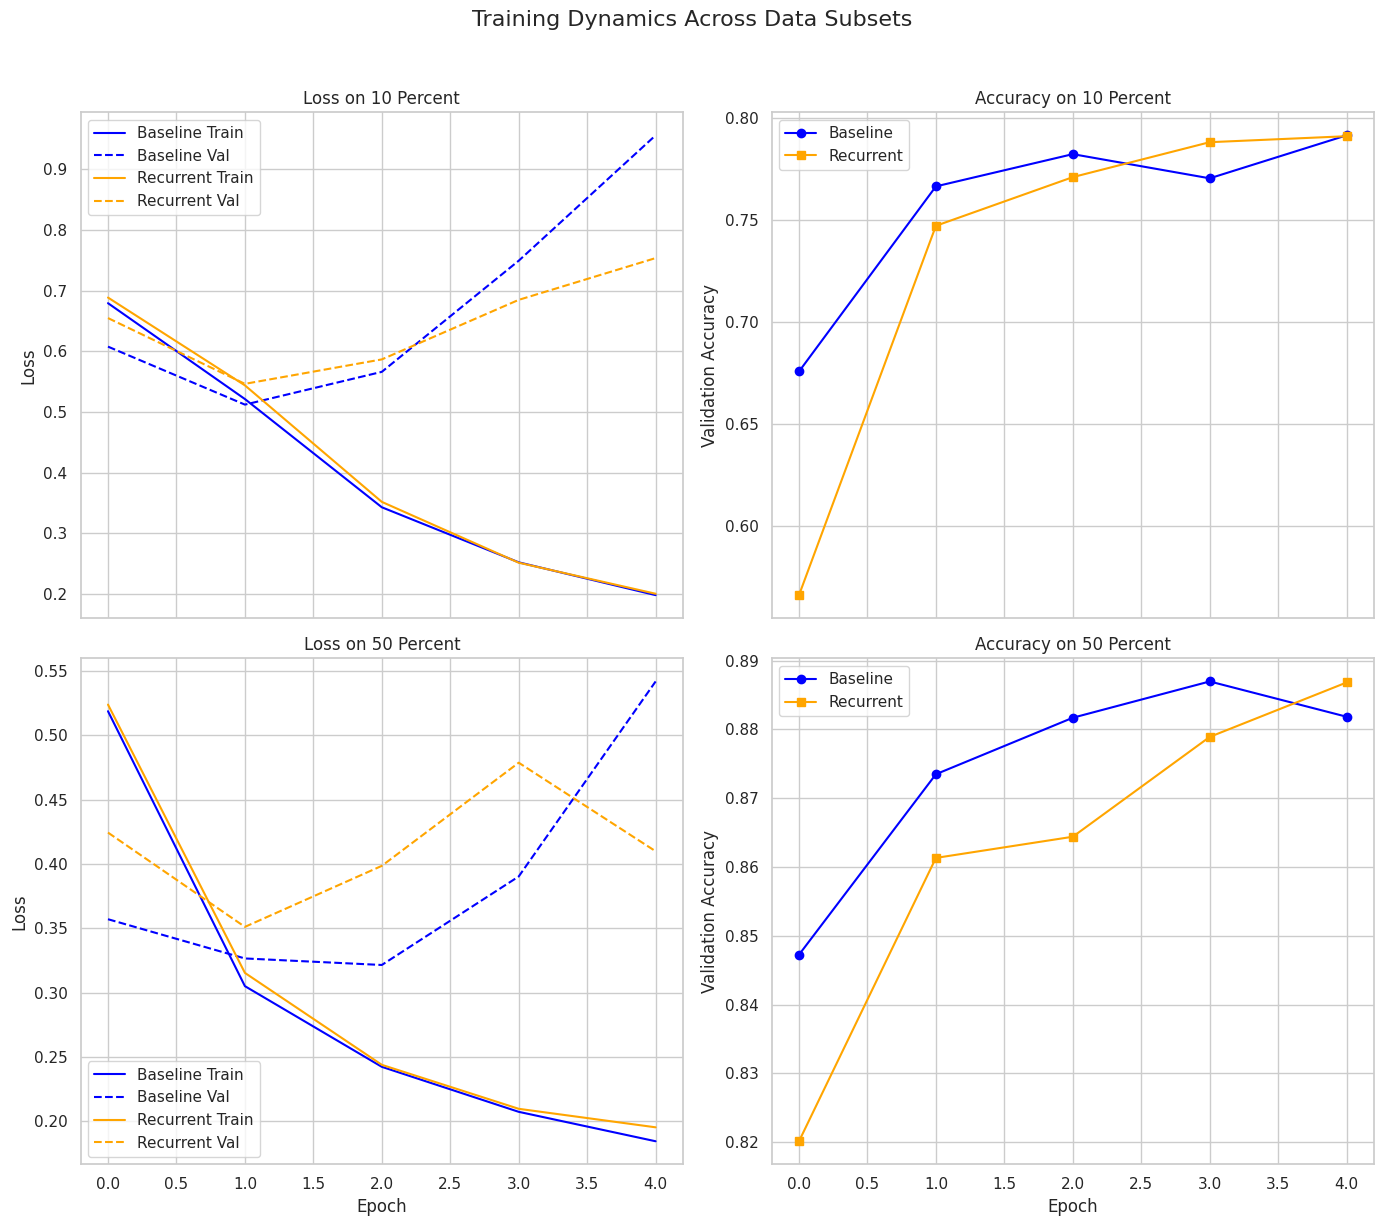

In [ ]:
# Plot training curves
fig, axes = plt.subplots(len(DATA_SUBSETS), 2, figsize=(14, 6 * len(DATA_SUBSETS)), sharex='col')
fig.suptitle('Training Dynamics Across Data Subsets', fontsize=16, y=1.02)

for i, subset in enumerate(DATA_SUBSETS):
    ax_loss = axes[i][0]
    ax_acc = axes[i][1]

    # Plot loss
    baseline_hist = training_histories[subset]['Baseline']
    recurrent_hist = training_histories[subset]['Recurrent']

    ax_loss.plot(baseline_hist['train_loss'], label='Baseline Train', color='blue', linestyle='-')
    ax_loss.plot(baseline_hist['val_loss'], label='Baseline Val', color='blue', linestyle='--')
    ax_loss.plot(recurrent_hist['train_loss'], label='Recurrent Train', color='orange', linestyle='-')
    ax_loss.plot(recurrent_hist['val_loss'], label='Recurrent Val', color='orange', linestyle='--')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title(f'Loss on {subset.replace("_", " ").title()}')
    ax_loss.legend()

    # Plot accuracy
    ax_acc.plot(baseline_hist['val_acc'], label='Baseline', color='blue', marker='o')
    ax_acc.plot(recurrent_hist['val_acc'], label='Recurrent', color='orange', marker='s')
    ax_acc.set_ylabel('Validation Accuracy')
    ax_acc.set_title(f'Accuracy on {subset.replace("_", " ").title()}')
    ax_acc.legend()

axes[-1][0].set_xlabel('Epoch')
axes[-1][1].set_xlabel('Epoch')
plt.tight_layout()
plt.show()

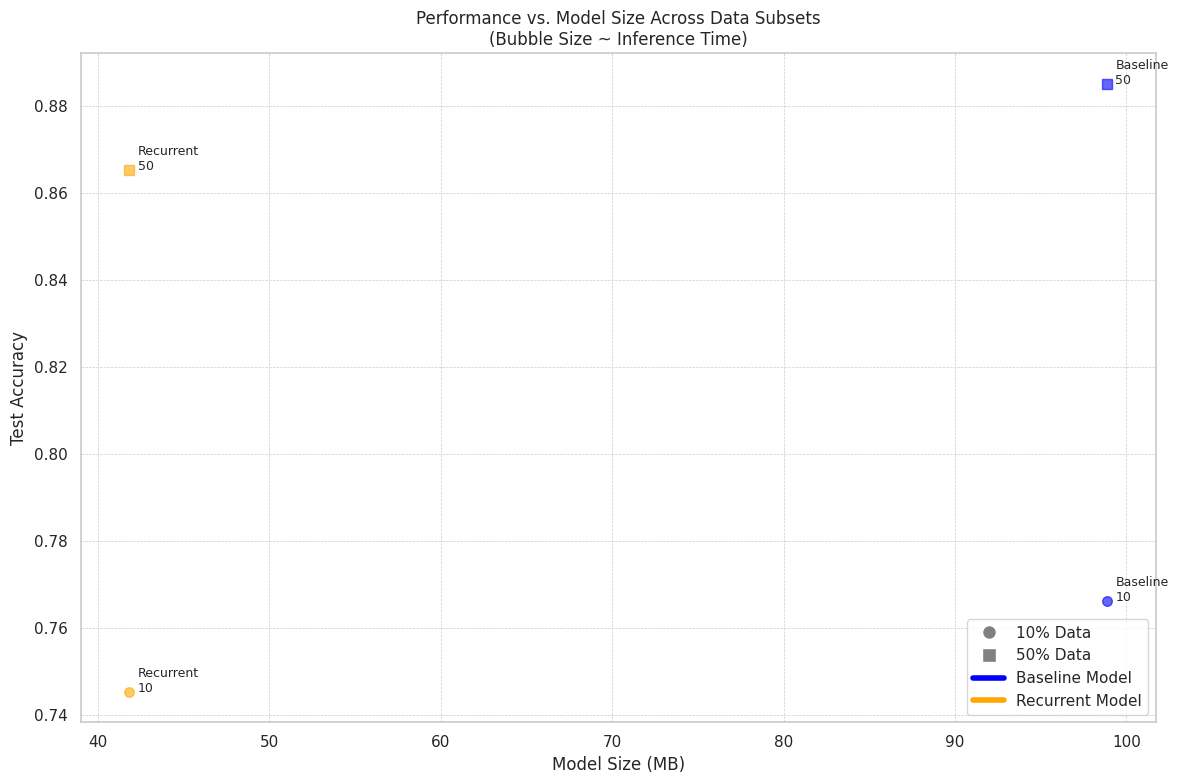

In [ ]:
# Bubble plot for performance comparison
plt.figure(figsize=(12, 8))

markers = {
    '10_percent': 'o', # Circle
    '50_percent': 's'  # Square
}
colors = {
    'Baseline': 'blue',
    'Recurrent': 'orange'
}

for i, row in results_df.iterrows():
    plt.scatter(
        row['Size (MB)'],
        row['accuracy'],
        s=row['inference_time_ms'] * 150, # Bubble size by inference time
        c=colors[row['Model']],
        marker=markers[row['Subset']],
        alpha=0.6,
        label=f"{row['Model']} {row['Subset']}" if i < 4 else "" # Avoid duplicate labels
    )
    plt.text(row['Size (MB)']+0.5, row['accuracy'], f"{row['Model']}\n{row['Subset'].split('_')[0]}", fontsize=9)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='10% Data', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='s', color='w', label='50% Data', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], color='blue', lw=4, label='Baseline Model'),
    Line2D([0], [0], color='orange', lw=4, label='Recurrent Model')
]

plt.xlabel('Model Size (MB)')
plt.ylabel('Test Accuracy')
plt.title('Performance vs. Model Size Across Data Subsets\n(Bubble Size ~ Inference Time)')
plt.legend(handles=legend_elements, loc='lower right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
